Wayne H Nixalo - 09 Aug 2017

FADL2 L9: Generative Models

neural-style-GPU.ipynb

In [33]:
%matplotlib inline
import importlib
import os, sys
sys.path.insert(1, os.path.join('../utils'))
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

In [2]:
limit_mem()

In [4]:
path = '../data/nst/'

In [14]:
# names = os.listdir(path)
# pkl_out = open('fnames.pkl','wb')
# pickle.dump(names, pkl_out)
# pkl_out.close()

fnames = pickle.load(open(path + 'fnames.pkl', 'rb'))

In [16]:
fnames = glob.glob(path+'**/*.JPG', recursive=True)
fn = fnames[0]

In [17]:
fn

'../data/nst/IMG_2934.JPG'

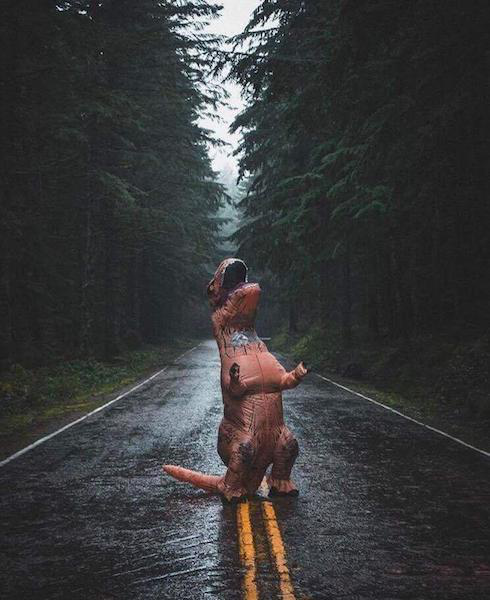

In [18]:
img = Image.open(fn); img

In [19]:
# Subtracting mean and reversing color-channel order:
rn_mean = np.array([123.68,116.779,103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:,:,:,::-1]

# later undoing preprocessing for image generation
deproc = lambda x,s: np.clip(x.reshape(s)[:,:,:,::-1] + rn_mean, 0, 255)

img_arr = preproc(np.expand_dims(np.array(img), 0))
shp     = img_arr.shape

### Content Recreation

In [30]:
# had to fix some compatibility issues w/ Keras 1 -> Keras 2
import vgg16_avg
importlib.reload(vgg16_avg)
from vgg16_avg import VGG16_Avg

In [31]:
model = VGG16_Avg(include_top=False)
# grabbing activations from near the end of the CNN model
layer = model.get_layer('block5_conv1').output
# calculating layer's target activations
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

../utils/vgg16_avg.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv1", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv1')(img_input)
../utils/vgg16_avg.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="block1_conv2", padding="same")`
  x = Convolution2D(64, 3, 3, activation='relu', border_mode='same', name='block1_conv2')(x)
../utils/vgg16_avg.py:61: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv1", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode='same', name='block2_conv1')(x)
../utils/vgg16_avg.py:62: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="block2_conv2", padding="same")`
  x = Convolution2D(128, 3, 3, activation='relu', border_mode=

58728448/58889256 [============================>.] - ETA: 0s

In this implementation, need to define an object that'll allow us to separately access the loss function and gradients of a function, 

In [34]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
    
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)
    
    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

# Define loss function to calc MSE betwn the 2 outputs at specfd Conv layer
loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

# optimize loss fn w/ deterministic approach using Line Search
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{path}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

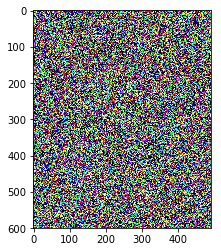

In [35]:
# generating a random image:
rand_img = lambda shape: np.random.uniform(-2.5,2.5,shape)/100
x = rand_img(shp)
plt.imshow(x[0])

In [36]:
iterations = 10
x = solve_image(evaluator, iterations, x)

Current loss value: [[[  36.84698486   25.31944656   19.05295372   26.72929001   42.29379272
     42.4466095    36.8651123    25.77234459   31.87740707   43.05461121
     47.14723969   48.08355713   85.19512177   74.53987122   90.32463837
     52.39159012   59.66118622   64.09477234   35.54707336   19.38749695
     26.45584297   29.91149139   31.43980217   29.77198219   24.52454376
     25.90310478   28.49525833   26.08754349   22.75306129   19.04619026]
  [  22.21642303   20.12755775   14.17131519   17.12739944   22.81347847
     16.16996193   11.96669006   14.62566471   21.61488914   29.53083038
     34.73329544   46.74581909   58.82113266   44.07838821   41.14895248
     40.42720032   86.28344727   69.63314056   23.93707848   14.28123856
     15.62097168   15.23616982   14.34072685   18.44782257   14.81083012
     15.40630436   17.61517525   17.93347931   15.7487011     9.74167347]
  [  19.57742691   24.88094711   21.20959854   17.02429199   16.04206276
     11.64803505   10.1634492

Current loss value: [[[  36.84698486   25.31944656   19.05295372   26.72929001   42.29379272
     42.4466095    36.8651123    25.77234459   31.87740707   43.05461121
     47.14723969   48.08355713   85.19512177   74.53987122   90.32463837
     52.39159012   59.66118622   64.09477234   35.54707336   19.38749695
     26.45584297   29.91149139   31.43980217   29.77198219   24.52454376
     25.90310478   28.49525833   26.08754349   22.75306129   19.04619026]
  [  22.21642303   20.12755775   14.17131519   17.12739944   22.81347847
     16.16996193   11.96669006   14.62566471   21.61488914   29.53083038
     34.73329544   46.74581909   58.82113266   44.07838821   41.14895248
     40.42720032   86.28344727   69.63314056   23.93707848   14.28123856
     15.62097168   15.23616982   14.34072685   18.44782257   14.81083012
     15.40630436   17.61517525   17.93347931   15.7487011     9.74167347]
  [  19.57742691   24.88094711   21.20959854   17.02429199   16.04206276
     11.64803505   10.1634483

Current loss value: [[[  36.84698486   25.31944656   19.05295372   26.72929001   42.29379272
     42.4466095    36.8651123    25.77234459   31.87740707   43.05461121
     47.14723969   48.08355713   85.19512177   74.53987122   90.32463837
     52.39159012   59.66118622   64.09477234   35.54707336   19.38749695
     26.45584297   29.91149139   31.43980217   29.77198219   24.52454376
     25.90310478   28.49525833   26.08754349   22.75306129   19.04619026]
  [  22.21642303   20.12755775   14.17131519   17.12739944   22.81347847
     16.16996193   11.96669006   14.62566471   21.61488914   29.53083038
     34.73329544   46.74581909   58.82113266   44.07838821   41.14895248
     40.42720032   86.28344727   69.63314056   23.93707848   14.28123856
     15.62097168   15.23616982   14.34072685   18.44782257   14.81083012
     15.40630436   17.61517525   17.93347931   15.7487011     9.74167347]
  [  19.57742691   24.88094711   21.20959854   17.02429199   16.04206276
     11.64803505   10.1634483

Current loss value: [[[  36.84698486   25.31944656   19.05295372   26.72929001   42.29379272
     42.4466095    36.8651123    25.77234459   31.87740707   43.05461121
     47.14723969   48.08355713   85.19512177   74.53987122   90.32463837
     52.39159012   59.66118622   64.09477234   35.54707336   19.38749695
     26.45584297   29.91149139   31.43980217   29.77198219   24.52454376
     25.90310478   28.49525833   26.08754349   22.75306129   19.04619026]
  [  22.21642303   20.12755775   14.17131519   17.12739944   22.81347847
     16.16996193   11.96669006   14.62566471   21.61488914   29.53083038
     34.73329544   46.74581909   58.82113266   44.07838821   41.14895248
     40.42720032   86.28344727   69.63314056   23.93707848   14.28123856
     15.62097168   15.23616982   14.34072685   18.44782257   14.81083012
     15.40630436   17.61517525   17.93347931   15.7487011     9.74167347]
  [  19.57742691   24.88094711   21.20959854   17.02429199   16.04206276
     11.64803505   10.1634483

KeyboardInterrupt: 

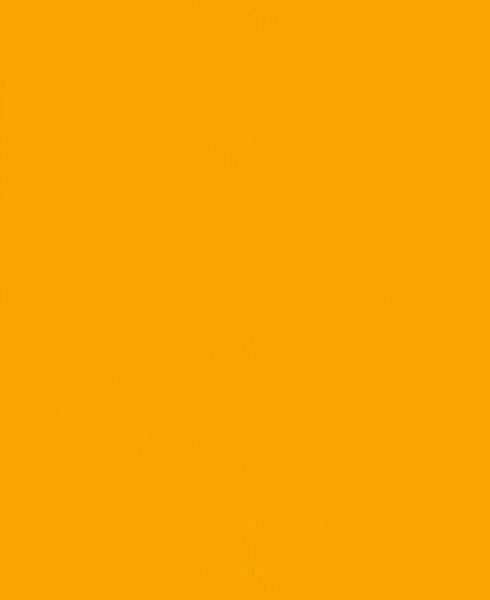

In [41]:
Image.open(path + 'results/res_at_iteration_1.png')

In [ ]:
# Looking at result for earlier Conv block (4):
layer = model.get_layer('block4_conv1').output
layer_model = Model(model.input, layer)
targ = K.variable(layer_model.predict(img_arr))

loss = metrics.mse(layer, targ)
grads = K.gradients(loss, model.input)
fn = K.function([model.input], [loss]+grads)
evaluator = Evaluator(fn, shp)

x = solve_image(evaluator, iterations, x)

In [ ]:
Image.open(path + 'results/res_at_iteration_9.png')